Looking for the most likely cause of the decrease in Nea. % over the last 10 thousand years.

This is the time period for which we have 6 higher coverage EMHs, all from around 8 kya.

Main idea - if we restrict to super-neutral sites and we see shift in the distribution of Nea. allele frequencies, this is an evidence of migration.

If we see a significant shift at non-neutral sites *beyond* of what is observed on the super-neutral sites, this can be interpreted as selection.

*Why would this work?* After > 40k years after introgression, the individual blocks should be broken down enough so that we can stop worrying about linkage so much. We can therefore have a better idea of which SNPs are super-neutral, compared to early EMHs where, due to longer haplotypes, filtering for superneutral SNPs is problematic (i.e. how far from the informative site we want to filter potential conserved regions?)

**TODO:** Calculate the expected length of Nea. haplotype over time to justify this.

**TODO**: Would it make sense to use the BAM files of the later EMHs and aggregate all the available reads to have a better idea of the actual Nea. introgressed allele frequencies or would it be too much effort?

**TODO**: Make sure to use only sites for which you have sites available from all later EMHs?

In [27]:
suppressPackageStartupMessages({
    library(tidyverse);
    library(stringr);
    library(magrittr);
    library(modelr);
    library(broom);
    library(purrr)
})

source("../R/utils.R")

In [28]:
files <- list.files("../clean_data/annotations/", pattern="priPhCons__100000bp.bed", full.names=TRUE)

window_avgs_long <- lapply(files, function(f) {
    read.table(f, header=FALSE) %>%
        .[1:4] %>%
        setNames(c("chrom", "start", "end", "value")) %>%
        mutate(track=str_replace(basename(f), ".bed", ""))
}) %>%
    bind_rows %>%
    rename(pos=end) %>% 
    select(-start)

window_avgs_wide <- spread(window_avgs_long, track, value)

In [29]:
suppressMessages(
    cadd_wide <-
        load_annotations("../clean_data/annotations.tsv") %>%
        select(chrom, pos, bStatistic, Consequence, AnnoType)
)

Warning message:
“673 parsing failures.
 row            col               expected  actual
2136 mapAbility35bp no trailing characters .5     
4607 mapAbility35bp no trailing characters .333333
5028 mapAbility35bp no trailing characters .5     
5379 mapAbility35bp no trailing characters .5     
5819 mapAbility35bp no trailing characters .5     
.... .............. ...................... .......
See problems(...) for more details.
”

In [30]:
all_annots_wide <- inner_join(window_avgs_wide, cadd_wide)

Joining, by = c("chrom", "pos")


In [31]:
colnames(all_annots_wide)[3:ncol(all_annots_wide)]

[1] "priPhCons__100000bp" "bStatistic"          "Consequence"        
[4] "AnnoType"

In [32]:
table(all_annots_wide$AnnoType)


   CodingTranscript          Intergenic NonCodingTranscript   RegulatoryFeature 
               8275              440179                8398              100604 
         Transcript 
             387901 

In [44]:
suppressMessages({

# read processed SNP tables of aDNA samples and SGDP individuals,
# merge them and intersect them with the annotations data
all_snps <- load_dataset("../clean_data/ice_age.tsv",
                         "../clean_data/sgdp.tsv",
                         "../clean_data/archaics.tsv",
                         filter_damage=FALSE,
                         metadata_path="../raw_data/10_24_2014_SGDP_metainformation_update.txt",
                         random_sample=T)

# process the SGDP metainformation table
sgdp_info <-
  load_sgdp_info("../raw_data/10_24_2014_SGDP_metainformation_update.txt") %>%
  mutate(name=str_replace(name, "^S_", "")) %>%
  filter(name %in% colnames(all_snps)) %>%
  mutate(age=0) %>%
  rename(pop=Region) %>%
  filter(pop == "WestEurasia") %>%
  mutate(pop="present_Europe") %>% 
  filter(! Country %in% c('Iran', 'Iraq', 'Jordan', 'Israel(Central)',
                          'Israel(Carmel)', 'Israel(Negev)', 'Israel', 'Tajikistan', 'Turkey', 'Yemen',
                          'Abkhazia', 'Armenia'))

emh_info <- # filter out high C-T samples (mainly non-UDG treated ones and weird library preps)
  read_delim("../clean_data/ages.txt", delim=" ") %>%
  mutate(pop="EMH_Europe") %>%
  filter(name %in% colnames(all_snps),
         ! name %in% c("AfontovaGora3", "GoyetQ116_1", "Kotias", "Oase1", "Satsurblia", "Villabruna"))

samples_info <-
  bind_rows(emh_info, sgdp_info) %>%
  mutate(post_admixture=55000 - age) %>%
  filter(age < 10000, name != "Stuttgart") # filter out Stuttgart, which is known to have basal Eurasian ancestry

})

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”Warning message in one_of(sgdp_info$name):
“Unknown variables: `S_Australian_1`, `S_Australian_5`”Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”

In [45]:
samples_info %>% group_by(pop) %>% count()

pop,n
EMH_Europe,5
present_Europe,43


In [46]:
select(filter(samples_info, pop == "EMH_Europe"), name, age, pop)

name,age,pop
Karelia,8375,EMH_Europe
Loschbour,8050,EMH_Europe
LaBrana1,7815,EMH_Europe
Hungarian_KO1,7660,EMH_Europe
Motala12,7625,EMH_Europe


In [47]:
select(filter(samples_info, pop == "present_Europe"), name, age, pop, Country)

name,age,pop,Country
Abkhasian_2,0,present_Europe,Russia
Adygei_1,0,present_Europe,Russia(Caucasus)
Adygei_2,0,present_Europe,Russia(Caucasus)
Albanian_1,0,present_Europe,Albania
Basque_1,0,present_Europe,France
Basque_2,0,present_Europe,France
Bergamo_2,0,present_Europe,Italy(Bergamo)
Bulgarian_1,0,present_Europe,Bulgaria
Bulgarian_2,0,present_Europe,Bulgaria
Chechen_1,0,present_Europe,Russia


Filter SNPs for early/present-day  European samples only:

In [48]:
all_snps %<>% select(c(chrom, pos,
                       one_of(as.character(samples_info$name))))

In [49]:
head(all_snps)

chrom,pos,Karelia,Loschbour,LaBrana1,Hungarian_KO1,Motala12,Abkhasian_2,Adygei_1,Adygei_2,⋯,Orcadian_2,Polish_1,Russian_1,Russian_2,Sardinian_1,Sardinian_2,Spanish_1,Spanish_2,Tuscan_1,Tuscan_2
1,847983,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1,853089,0,0,0,NA,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1,853596,NA,0,0,NA,NA,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1,854793,0,0,0,NA,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1,867552,0,0,0,NA,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1,871401,NA,0,0,NA,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


What are the couts of missing sites in the EMH data?

In [50]:
select(all_snps, Karelia:Motala12) %>% apply(1, function(r) sum(is.na(r))) %>% as.vector %>% table

.
     0      1      2      3      4      5 
158166 201611  93835  24099   3770   2535 

What are the couts of missing sites in the present-day data?

In [51]:
select(all_snps, Abkhasian_2:Tuscan_2) %>% apply(1, function(r) sum(is.na(r))) %>% table

.
     0      1      2      3      4      5      6      7      8      9     10 
482573    538    230    177     82     72     70     44     26     24     22 
    11     12     13     14     15     16     17     18     19     20     21 
    15     18      8     11      9     11     13     10      6      6      2 
    22     23     24     25     26     27     28     29     30     31     35 
     5      6      4      4      2      7      4      1      3      2      1 
    36     37     40     43 
     4      1      1      4 

What are the couts of sites missing in all data?

In [52]:
all_snps[2:ncol(all_snps)] %>% apply(1, function(r) sum(is.na(r))) %>% table

.
     0      1      2      3      4      5      6      7      8      9     10 
157955 201396  93653  24036   3803   2618    109     82     58     46     41 
    11     12     13     14     15     16     17     18     19     20     21 
    28     13     17     12     17     16     10      8      7     12     11 
    22     23     24     25     26     27     28     29     31     32     33 
     7      5      7      2      4      3      7      4      4      6      2 
    34     35     38     39     41     45     48 
     1      5      3      2      1      1      4 

Filter for sites with information from all individuals

In [101]:
emh_na_counts     <- select(all_snps, Karelia:Motala12)     %>% apply(1, function(r) sum(is.na(r)))
present_na_counts <- select(all_snps, Abkhasian_2:Tuscan_2) %>% apply(1, function(r) sum(is.na(r)))

In [104]:
all_snps <- filter(all_snps, emh_na_counts == 0 & present_na_counts == 0)

In [105]:
nrow(all_snps)

[1] 157955

Create a lookup table of sample population assignments:

In [106]:
pop_table <- samples_info$pop
names(pop_table) <- samples_info$name

Merge annotations with SNP data and convert the DF into a long format:

In [109]:
merged <-
    inner_join(all_annots_wide, all_snps) %>% # merge annotations with SNP data
    mutate(chrom=paste0(chrom, "_", pos)) %>% # create a SNP ID string
    rename(site_id=chrom) %>%  select(-pos)   # remove the chrom/pos columns

Joining, by = c("chrom", "pos")


In [113]:
sites <-
    gather(merged, name, allele, -site_id, -AnnoType, -Consequence, -priPhCons__100000bp, -bStatistic) %>%
    mutate(pop=pop_table[name],
           allele=ifelse(allele == 2, 1, 0))
           #allele=ifelse(allele == 0, 0, ifelse(allele == 1, 0.5, ifelse(allele == 2, 1, NA))))

In [114]:
head(sites)

site_id,priPhCons__100000bp,bStatistic,Consequence,AnnoType,name,allele,pop
1_847983,0.047667,958,NONCODING_CHANGE,NonCodingTranscript,Karelia,0,EMH_Europe
1_1131600,0.031456,873,INTRONIC,Transcript,Karelia,0,EMH_Europe
1_1193746,0.040323,769,REGULATORY,RegulatoryFeature,Karelia,0,EMH_Europe
1_1195565,0.040551,779,REGULATORY,RegulatoryFeature,Karelia,0,EMH_Europe
1_1200468,0.045850,784,REGULATORY,RegulatoryFeature,Karelia,0,EMH_Europe
1_1696390,0.055556,662,INTRONIC,Transcript,Karelia,0,EMH_Europe


In [115]:
str(sites)

'data.frame':	7581840 obs. of  8 variables:
 $ site_id            : chr  "1_847983" "1_1131600" "1_1193746" "1_1195565" ...
 $ priPhCons__100000bp: num  0.0477 0.0315 0.0403 0.0406 0.0459 ...
 $ bStatistic         : int  958 873 769 779 784 662 653 682 716 774 ...
 $ Consequence        : chr  "NONCODING_CHANGE" "INTRONIC" "REGULATORY" "REGULATORY" ...
 $ AnnoType           : chr  "NonCodingTranscript" "Transcript" "RegulatoryFeature" "RegulatoryFeature" ...
 $ name               : chr  "Karelia" "Karelia" "Karelia" "Karelia" ...
 $ allele             : num  0 0 0 0 0 0 0 0 0 0 ...
 $ pop                : Named chr  "EMH_Europe" "EMH_Europe" "EMH_Europe" "EMH_Europe" ...
  ..- attr(*, "names")= chr  "Karelia" "Karelia" "Karelia" "Karelia" ...


Calculate the SFS of introgressed alleles at each available time point

In [116]:
sfs <- group_by(sites, pop, site_id, AnnoType, priPhCons__100000bp, bStatistic) %>%
    summarise(f=mean(allele)) %>% 
    #summarise(f=mean(0.5 * allele)) %>% -- this is for the case of 0/1/2 alleles
    #summarise(f=mean(allele), na.rm=TRUE) %>% -- not necessary after filtering out NA before, also no random calls
    # filter(!is.nan(f)) %>% -- not necessary either
    ungroup

In [117]:
filter(sfs, site_id == "1_2068714")

pop,site_id,AnnoType,priPhCons__100000bp,bStatistic,f
EMH_Europe,1_2068714,Intergenic,0.034121,851,0.4000000
present_Europe,1_2068714,Intergenic,0.034121,851,0.3488372


In [118]:
filter(sites, site_id == "1_2068714", pop == "EMH_Europe")

site_id,priPhCons__100000bp,bStatistic,Consequence,AnnoType,name,allele,pop
1_2068714,0.034121,851,DOWNSTREAM,Intergenic,Karelia,0,EMH_Europe
1_2068714,0.034121,851,DOWNSTREAM,Intergenic,Loschbour,0,EMH_Europe
1_2068714,0.034121,851,DOWNSTREAM,Intergenic,LaBrana1,1,EMH_Europe
1_2068714,0.034121,851,DOWNSTREAM,Intergenic,Hungarian_KO1,0,EMH_Europe
1_2068714,0.034121,851,DOWNSTREAM,Intergenic,Motala12,1,EMH_Europe


In [119]:
options(repr.plot.widht=6, repr.plot.height=4)

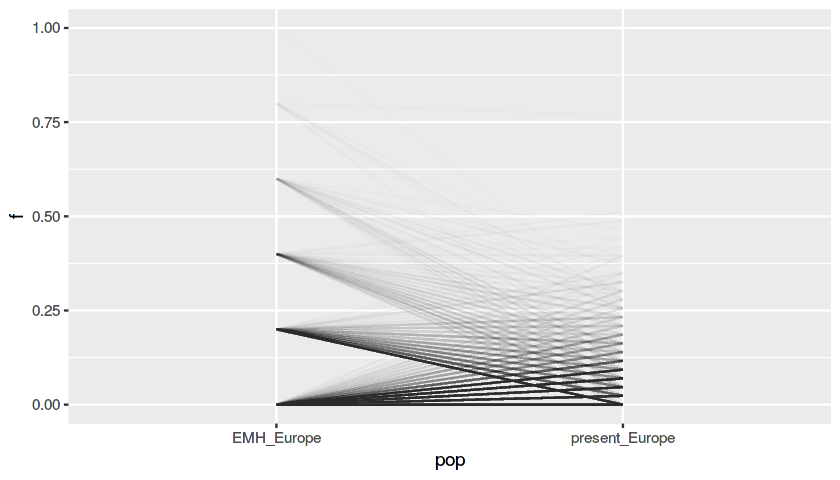

In [120]:
filter(sample_n(sfs, 75000)) %>% 
ggplot(aes(pop, f, group=site_id)) + geom_line(alpha=0.01) + ylim(0, 1)

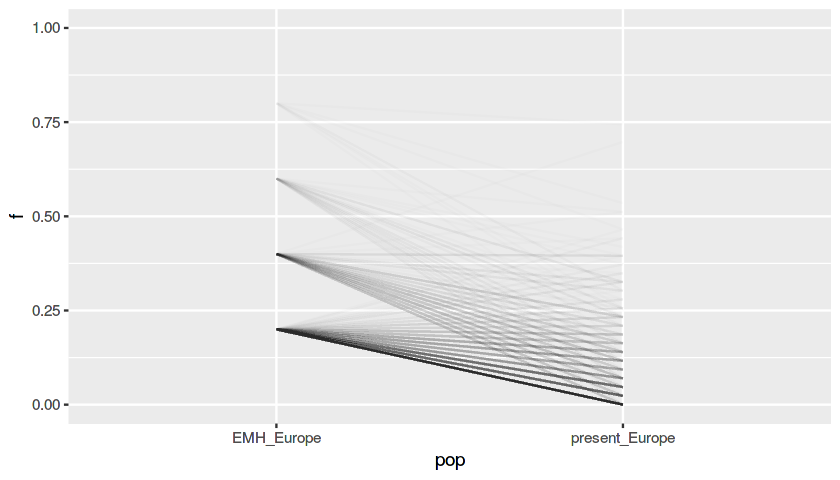

In [121]:
filter(sample_n(sfs, 75000), pop == "present_Europe" | (pop == "EMH_Europe" & (f > 0 & f < 1.0))) %>% 
ggplot(aes(pop, f, group=site_id)) + geom_line(alpha=0.01) + ylim(0, 1)

In [122]:
sfs_shift <-
    spread(sfs, pop, f) %>%
    mutate(freq_shift=present_Europe - EMH_Europe)

In [123]:
head(sfs_shift)

site_id,AnnoType,priPhCons__100000bp,bStatistic,EMH_Europe,present_Europe,freq_shift
1_100002713,Intergenic,0.112185,815,0,0.09302326,0.09302326
1_100030862,Intergenic,0.120319,857,0,0.06976744,0.06976744
1_100075381,Intergenic,0.129699,813,0,0.02325581,0.02325581
1_100101335,Intergenic,0.135984,757,0,0.02325581,0.02325581
1_100102248,Intergenic,0.136405,753,0,0.00000000,0.00000000
1_100105433,Intergenic,0.141346,759,0,0.04651163,0.04651163


## Genome annotation - coding/regulatory/intergenic

In [124]:
options(repr.plot.width=7, repr.plot.height=4)

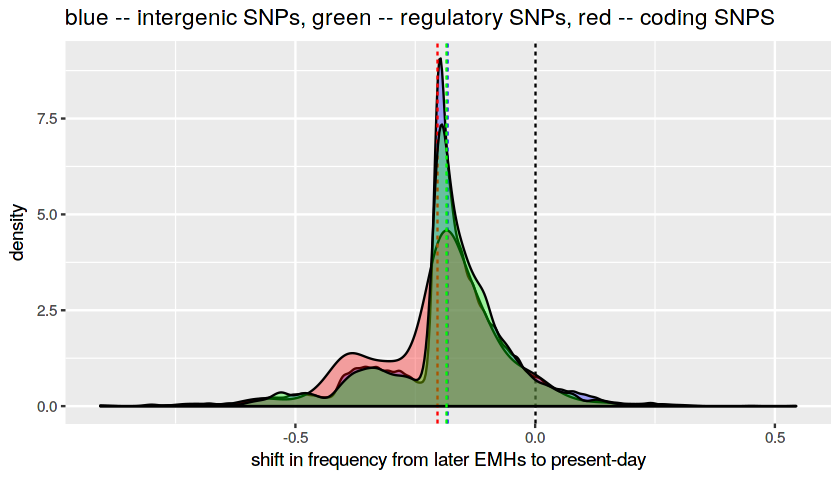

In [125]:
seg_in_emh <- filter(sfs_shift, EMH_Europe > 0, present_Europe < 1)

ggplot() +
    geom_vline(xintercept=0, linetype=2, color="black") +

    geom_density(data=filter(seg_in_emh, AnnoType == "Intergenic"), aes(freq_shift), alpha=1/3, fill="blue") +
    geom_vline(xintercept=mean(filter(seg_in_emh, AnnoType == "Intergenic")$freq_shift), linetype=2, color="blue") +

    geom_density(data=filter(seg_in_emh, AnnoType == "CodingTranscript"), aes(freq_shift), alpha=1/3, fill="red") +
    geom_vline(xintercept=mean(filter(seg_in_emh, AnnoType == "CodingTranscript")$freq_shift), linetype=2, color="red") +

    geom_density(data=filter(seg_in_emh, AnnoType == "RegulatoryFeature"), aes(freq_shift), alpha=1/3, fill="green") +
    geom_vline(xintercept=mean(filter(seg_in_emh, AnnoType == "RegulatoryFeature")$freq_shift), linetype=2, color="green") +

    xlab("shift in frequency from later EMHs to present-day") +
    ggtitle("blue -- intergenic SNPs, green -- regulatory SNPs, red -- coding SNPS")

In [126]:
summary(seg_in_emh$freq_shift)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.9070 -0.2000 -0.1767 -0.1806 -0.1070  0.5442 

## phastCons-based super-neutrality

In [129]:
(quantiles <- list(
    q5=quantile(merged$priPhCons__100000bp, probs=c(0.05, 0.95), na.rm=TRUE),
    q2=quantile(merged$priPhCons__100000bp, probs=c(0.02, 0.98), na.rm=TRUE),
    q1=quantile(merged$priPhCons__100000bp, probs=c(0.01, 0.99), na.rm=TRUE)
))

$q5
       5%       95% 
0.0660594 0.1921328 

$q2
        2%        98% 
0.05509008 0.22096300 

$q1
        1%        99% 
0.04573632 0.24436236

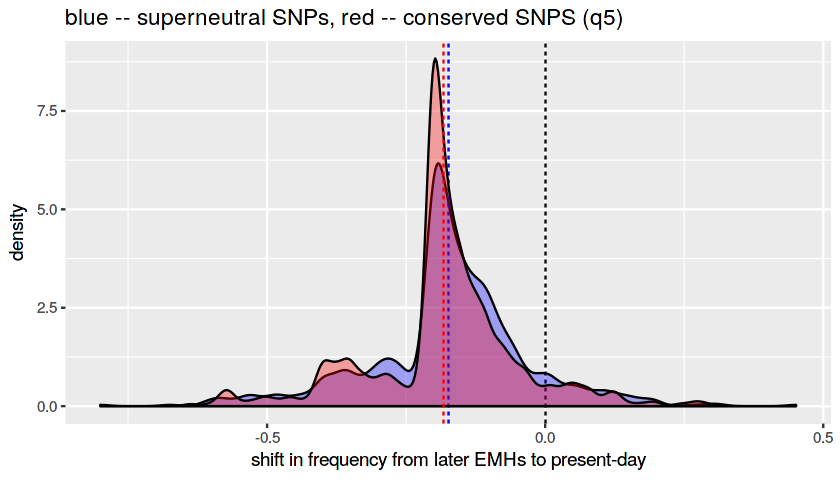

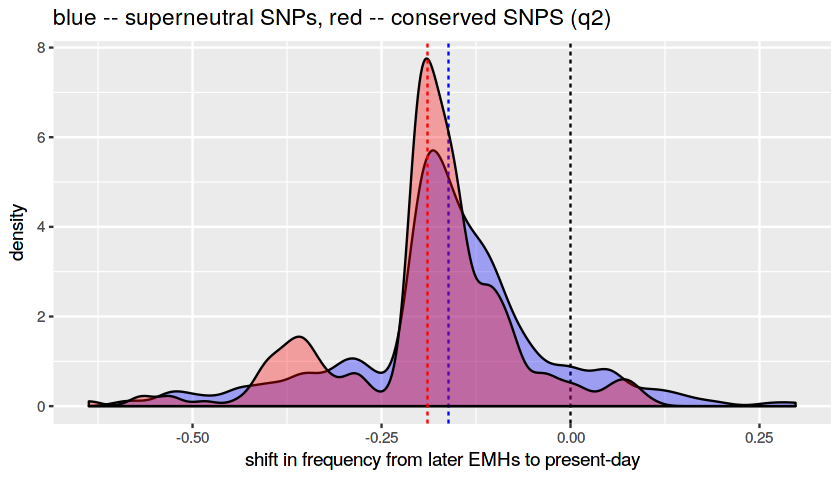

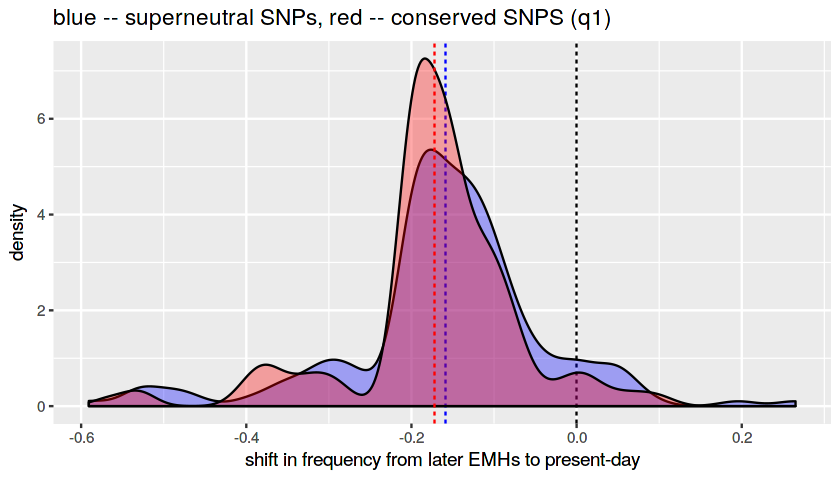

In [131]:
seg_in_emh <- filter(sfs_shift, EMH_Europe > 0, present_Europe < 1)

for (q in c("q5", "q2", "q1")) {
    print(
        ggplot() +
            geom_vline(xintercept=0, linetype=2, color="black") +

            geom_density(data=filter(seg_in_emh, priPhCons__100000bp < quantiles[[q]][1]), aes(freq_shift), alpha=1/3, fill="blue") +
            geom_vline(xintercept=mean(filter(seg_in_emh, priPhCons__100000bp < quantiles[[q]][1])$freq_shift), linetype=2, color="blue") +

            geom_density(data=filter(seg_in_emh, priPhCons__100000bp > quantiles[[q]][2]), aes(freq_shift), alpha=1/3, fill="red") +
            geom_vline(xintercept=mean(filter(seg_in_emh, priPhCons__100000bp > quantiles[[q]][2])$freq_shift), linetype=2, color="red") +

            xlab("shift in frequency from later EMHs to present-day") +
            ggtitle(paste0("blue -- superneutral SNPs, red -- conserved SNPS (", q, ")"))
    )
}

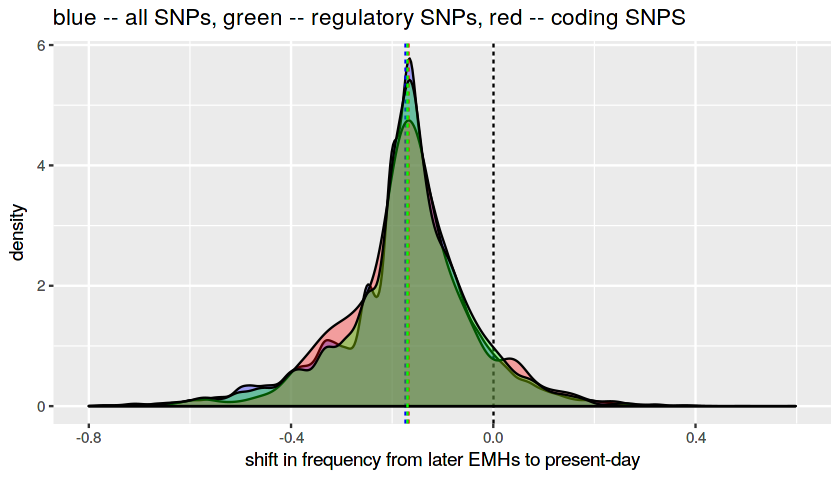

In [49]:
seg_in_emh <- filter(sfs_shift, later_emh > 0, later_emh < 1)

ggplot() +
    geom_vline(xintercept=0, linetype=2, color="black") +

    geom_density(data=filter(seg_in_emh, AnnoType == "Intergenic"), aes(freq_shift), alpha=1/3, fill="blue") +
    geom_vline(xintercept=mean(filter(seg_in_emh, AnnoType == "Intergenic")$freq_shift), linetype=2, color="blue") +

    geom_density(data=filter(seg_in_emh, AnnoType == "CodingTranscript"), aes(freq_shift), alpha=1/3, fill="red") +
    geom_vline(xintercept=mean(filter(seg_in_emh, AnnoType == "CodingTranscript")$freq_shift), linetype=2, color="red") +

    geom_density(data=filter(seg_in_emh, AnnoType == "RegulatoryFeature"), aes(freq_shift), alpha=1/3, fill="green") +
    geom_vline(xintercept=mean(filter(seg_in_emh, AnnoType == "RegulatoryFeature")$freq_shift), linetype=2, color="green") +

    xlab("shift in frequency from later EMHs to present-day") +
    ggtitle("blue -- all SNPs, green -- regulatory SNPs, red -- coding SNPS")

In [42]:
summary(seg_in_emh$freq_shift)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.8333 -0.2261 -0.1667 -0.1703 -0.1014  0.5978 

## phastCons-based super-neutrality

In [63]:
(quantiles <- list(
    q5=quantile(all_snps$priPhCons__100000bp, probs=c(0.05, 0.95), na.rm=TRUE),
    q2=quantile(all_snps$priPhCons__100000bp, probs=c(0.02, 0.98), na.rm=TRUE),
    q1=quantile(all_snps$priPhCons__100000bp, probs=c(0.01, 0.99), na.rm=TRUE)
))

$q5
      5%      95% 
0.065137 0.190970 

$q2
       2%       98% 
0.0540150 0.2183012 

$q1
        1%        99% 
0.04460688 0.24103436

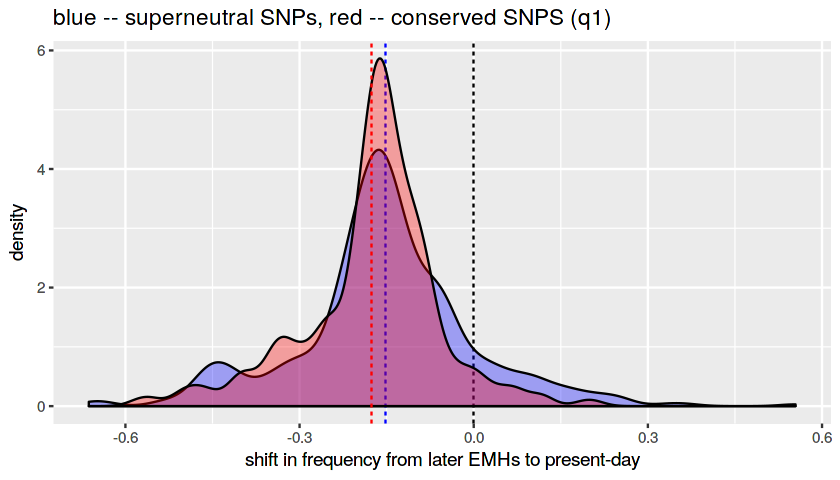

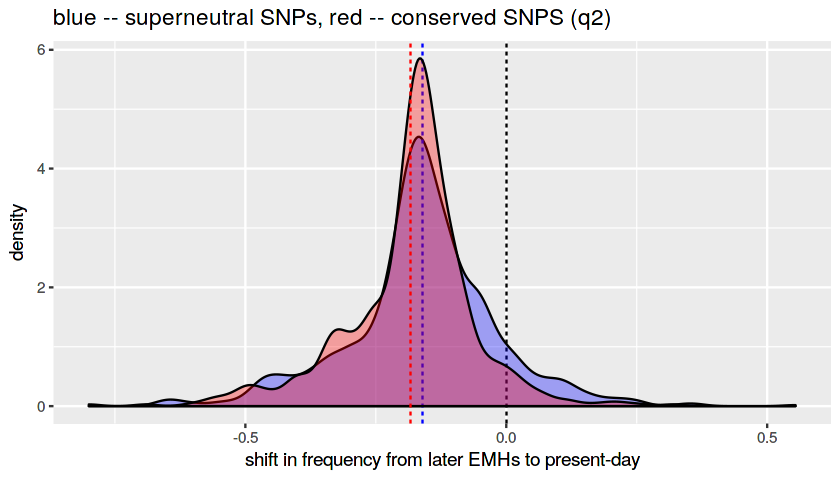

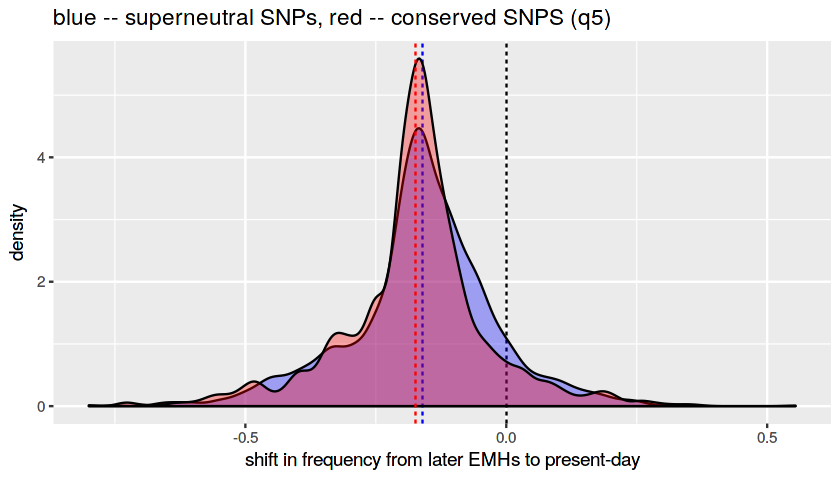

In [75]:
seg_in_emh <- filter(sfs_shift, later_emh > 0, later_emh < 1)

for (q in c("q5", "q2", "q1")) {
    print(
        ggplot() +
            geom_vline(xintercept=0, linetype=2, color="black") +

            geom_density(data=filter(seg_in_emh, priPhCons__100000bp < quantiles[[q]][1]), aes(freq_shift), alpha=1/3, fill="blue") +
            geom_vline(xintercept=mean(filter(seg_in_emh, priPhCons__100000bp < quantiles[[q]][1])$freq_shift), linetype=2, color="blue") +

            geom_density(data=filter(seg_in_emh, priPhCons__100000bp > quantiles[[q]][2]), aes(freq_shift), alpha=1/3, fill="red") +
            geom_vline(xintercept=mean(filter(seg_in_emh, priPhCons__100000bp > quantiles[[q]][2])$freq_shift), linetype=2, color="red") +

            xlab("shift in frequency from later EMHs to present-day") +
            ggtitle(paste0("blue -- superneutral SNPs, red -- conserved SNPS (", q, ")"))
    )
}

What is the best test to get a p-value for this analysis?